# Linear Regression: California Housing Dataset

This notebook presents a detailed analysis and predictive modeling workflow for estimating median house values in California districts using the well-known California Housing dataset from scikit-learn.

Housing price prediction is a classic regression problem with high practical relevance in economics, urban planning, and real estate. Accurate predictive models assist decision-makers in understanding market dynamics, allocating resources, and identifying key drivers of housing values.

This project explores a robust approach combining careful data preprocessing, feature engineering with transformations and outlier handling, and regularized linear regression to address potential multicollinearity issues. Rigorous evaluation and diagnostic visualization assess model fit quality and assumptions.

Key goals include:

- Understanding distributional characteristics of housing data features and addressing challenges like skewness and extreme values

- Managing multicollinearity to improve model stability and interpretability

- Identifying optimal regularization strength to prevent overfitting

- Evaluating model performance comprehensively with multiple metrics and visual diagnostics

- Providing actionable insights into model reliability and practical usage considerations

The notebook intends not only to develop a competitive regression model but also to encourage critical thinking about modeling assumptions, limitations, and real-world applicability.



## Importing Libraries and Loading the Dataset

In [226]:
# Importing Libraries
from sklearn.datasets import fetch_california_housing
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [227]:

# Loading the dataset
housing_data = fetch_california_housing()
print(f"{type(housing)} \nNOTE: A Bunch object is a container that extends the functionality of a standard Python dictionary.\nIt allows access to its items not only through dictionary-style key-value lookups (e.g., bunch['key']) but also through attribute-style access (e.g., bunch.key).\n\nTypecasting it into a dataframe...")

# Typecasting to dataframe
housing = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
print(f"[Typecasting successful]\n DataTyepe: {type(housing)}")

#Adding the target column (median house value) to the dataset
housing['MedHouseValue'] = housing_data.target

#printing the dataframe head
print(f"[Dataframe head]\n {housing.head()}\n")

# extracting columns from the dataset
columns = housing.columns.to_list()
print(f"[Columns extracted successfully]\nColumns: {columns}")

#defining feature and target in dataset
features = columns[:-1]
target = [columns[-1]]
print(f"\n[Features and Target defined successfully]\nFeatures: {features}\nTarget: {target}")

print("\n[Dataset Import Successfull]")

<class 'pandas.core.frame.DataFrame'> 
NOTE: A Bunch object is a container that extends the functionality of a standard Python dictionary.
It allows access to its items not only through dictionary-style key-value lookups (e.g., bunch['key']) but also through attribute-style access (e.g., bunch.key).

Typecasting it into a dataframe...
[Typecasting successful]
 DataTyepe: <class 'pandas.core.frame.DataFrame'>
[Dataframe head]
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseValue  
0    -122.23          4.526  
1    -122.22          3.585  
2    -122.24          3

## Exploratory Data Analysis

### Understanding the Dataset Structure

In [228]:
# number of rows, columns, and data types of each column
print(f"[DATASET SHAPE]\n shape: {housing.shape}")
print(f"\n[DATASET INFO]\n")
print(f"{housing.info()}")

# Count, mean, std deviation, min, max, quartiles for numeric features
print(f"\n[SUMMARY STATISTICS- DATASET DESCRIPTIVE STATISCTICS]\n {housing.describe()}")

[DATASET SHAPE]
 shape: (20640, 9)

[DATASET INFO]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MedInc         20640 non-null  float64
 1   HouseAge       20640 non-null  float64
 2   AveRooms       20640 non-null  float64
 3   AveBedrms      20640 non-null  float64
 4   Population     20640 non-null  float64
 5   AveOccup       20640 non-null  float64
 6   Latitude       20640 non-null  float64
 7   Longitude      20640 non-null  float64
 8   MedHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

[SUMMARY STATISTICS- DATASET DESCRIPTIVE STATISCTICS]
              MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.89982

The dataset has 20,640 rows and 9 columns (8 features and 1 target).

All columns are of type float64, indicating numerical data only.

There are no missing values; each column contains 20,640 non-null entries.

Descriptive statistics show the mean, standard deviation, min, max, and quartiles of each features:

- The `Population` column has a very high max value (35682), indicating potential outliers.

- `AveRooms` and `AveBedrms` show large ranges, suggesting skewness or extreme values in some areas.

- `AveOccup` has an extraordinarily large max value (1243.33), likely an anomaly.

This detailed insight helps plan next steps like handling outliers, feature transformations, and regression assumption checks.

### Missing Values and Duplicates

In [229]:
# Missing Data
print(f"[MISSING VALUES] \n{housing.isnull().sum()}")

# Duplicates
print(f"\n[DUPLICATES] \n{housing.duplicated().sum()}")

[MISSING VALUES] 
MedInc           0
HouseAge         0
AveRooms         0
AveBedrms        0
Population       0
AveOccup         0
Latitude         0
Longitude        0
MedHouseValue    0
dtype: int64

[DUPLICATES] 
0


The dataset has no missing values or duplicate records.

### Summary Statistics (Skewness and Kurtosis)

**Skewness**

Skewness measures the asymmetry of a distribution: how much the data leans to the left or right.

- A skewness near 0 means the data is roughly symmetric.

- Positive skewness (> +2) means a long right tail (more small values, few large ones).

- Negative skewness (< -2) means a long left tail (more large values, few small ones).

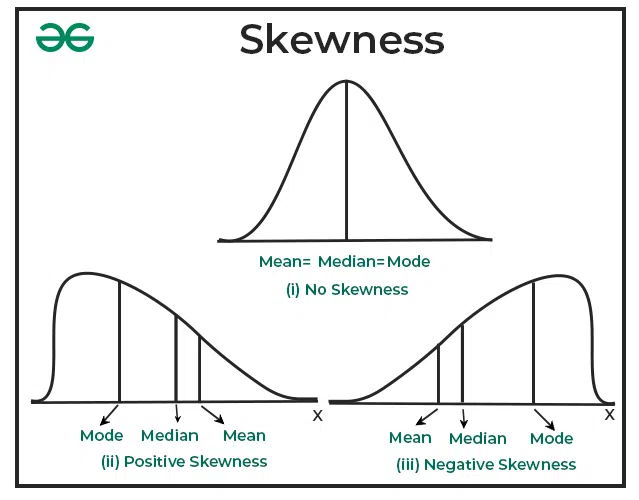

*Image Source And Credits:* Geeks for Geeks

**Skewness Impact on Linear Regression**

- Linear regression assumes that the residuals (errors between predicted and actual values) are normally distributed and symmetrically spread.

- High skewness (positive or negative) in features or residuals means the data is asymmetric, causing biases in coefficient estimates and poor model fit.

- Skewed features can lead to nonlinear relationships that violate the linearity assumption—the model may not capture patterns well.

- Remedies include transformations (log, square root) to reduce skewness and bring data closer to normality.

**Kurtosis**

Kurtosis measures the "tailedness" or extremity of outliers in the distribution compared to a normal distribution:

- Kurtosis near 0 (excess kurtosis) means normal-like tails.

- Positive kurtosis (> +2) means heavy tails and sharp peak (more extreme outliers).

- Negative kurtosis (< -2) means light tails and flatter peak.

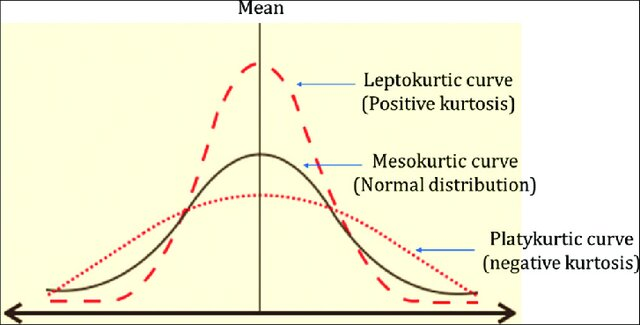

**Kurtosis Impact on Linear Regression**

- Kurtosis measures the "tailedness" or extremity of outliers.

- High positive kurtosis means heavy tails and many extreme outliers.

- Outliers can disproportionately influence the regression fit, make coefficient estimates unstable, and inflate error variance, violating homoscedasticity (constant variance of residuals).

- High kurtosis in residuals indicates poor model fit or missing nonlinear terms.

- Mitigating strategies include outlier detection and treatment, robust regression methods, or variable transformations.


In [230]:
# Calculating skewness for all columns (as all are numerical (float64))
def skew_kurt(columns):
  for col in columns:
    print(f"[FEATURE]: {col}")
    print(f"skewness: {skew(housing[col])}")
    print(f"kurtosis: {kurtosis(housing[col])}\n\n")

print("[Skewness and Kurtosis of columns]\n\n")
skew_kurt(housing.columns)

[Skewness and Kurtosis of columns]


[FEATURE]: MedInc
skewness: 1.64653702990008
kurtosis: 4.951033760409659


[FEATURE]: HouseAge
skewness: 0.06032625301661101
kurtosis: -0.8007255995444988


[FEATURE]: AveRooms
skewness: 20.69636472075092
kurtosis: 879.1399661167022


[FEATURE]: AveBedrms
skewness: 31.314680259248195
kurtosis: 1636.3152176836386


[FEATURE]: Population
skewness: 4.93549950885852
kurtosis: 73.53500881922278


[FEATURE]: AveOccup
skewness: 97.63246492211677
kurtosis: 10648.430333805287


[FEATURE]: Latitude
skewness: 0.46591914016270397
kurtosis: -1.117779708313892


[FEATURE]: Longitude
skewness: -0.29777956498586855
kurtosis: -1.3301208448425363


[FEATURE]: MedHouseValue
skewness: 0.9776922140978419
kurtosis: 0.3275001388119616




- Features like AveRooms, AveBedrms, AveOccup, and Population show very high skewness and kurtosis. These likely contain outliers or extreme values that may distort linear regression assumptions.

- Features with skewness and kurtosis near zero or within the range (-2, +2) generally satisfy normality assumptions better (e.g., HouseAge, Latitude, Longitude).

- Transformations (e.g., log, square root) of skewed features could reduce skewness and heavy tails.

- Outlier detection and possible removal or capping on extreme features will help stabilize the model.

**Visualizing These Distributions**

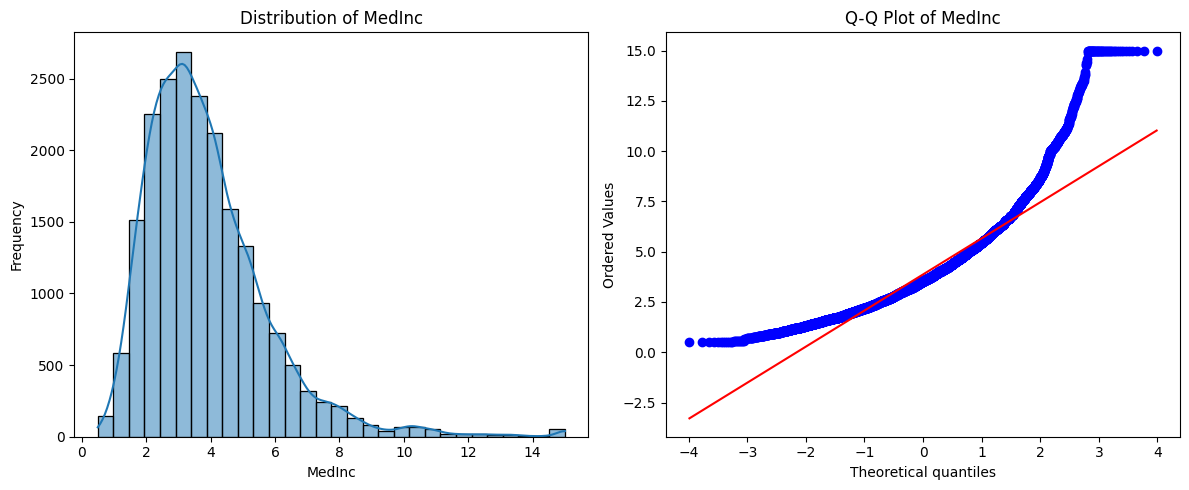

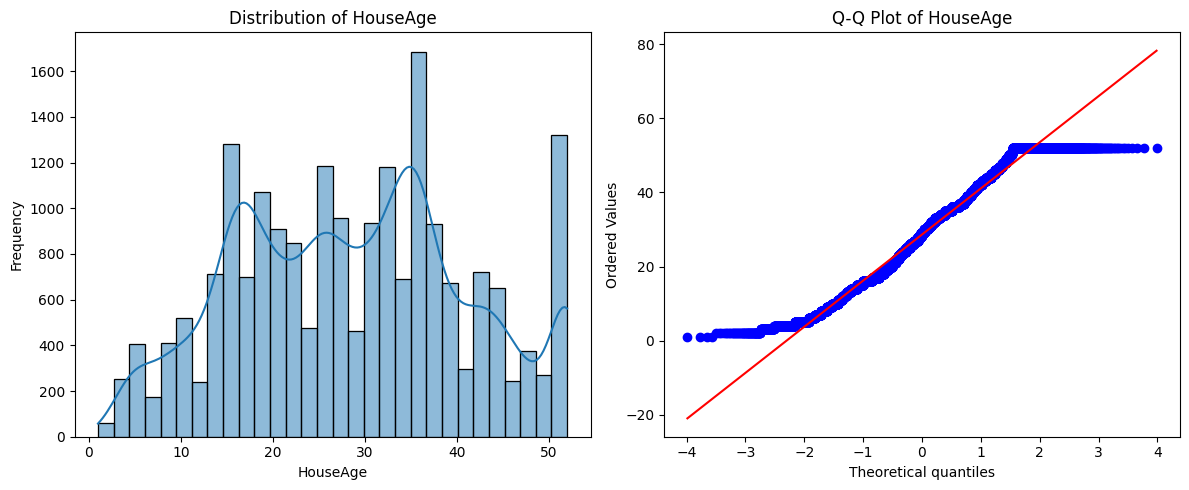

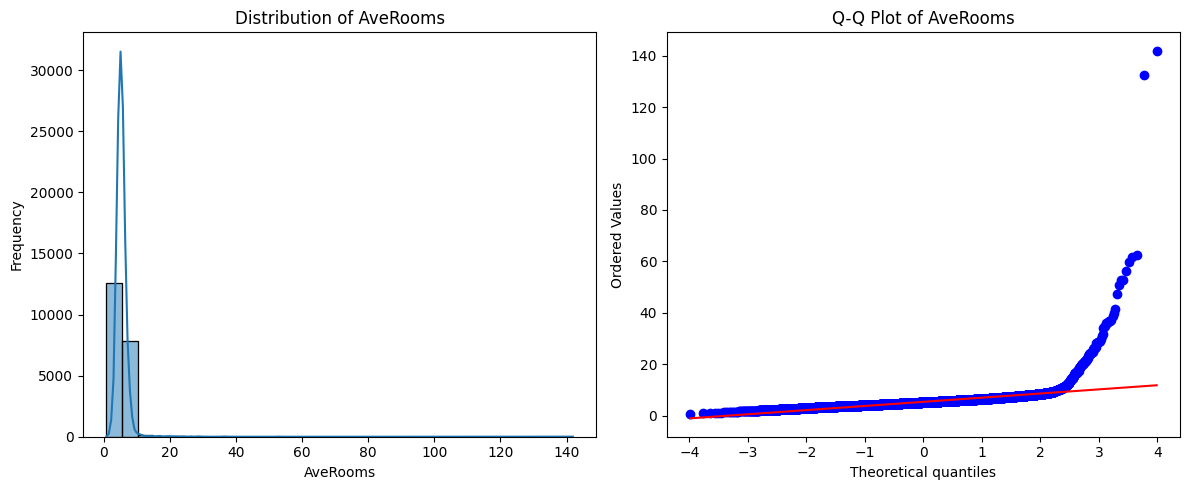

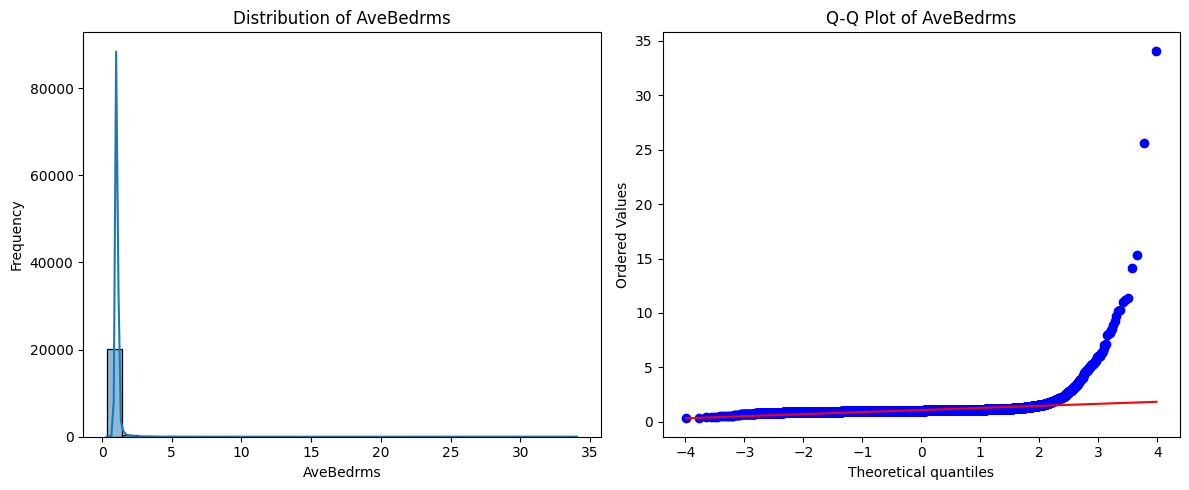

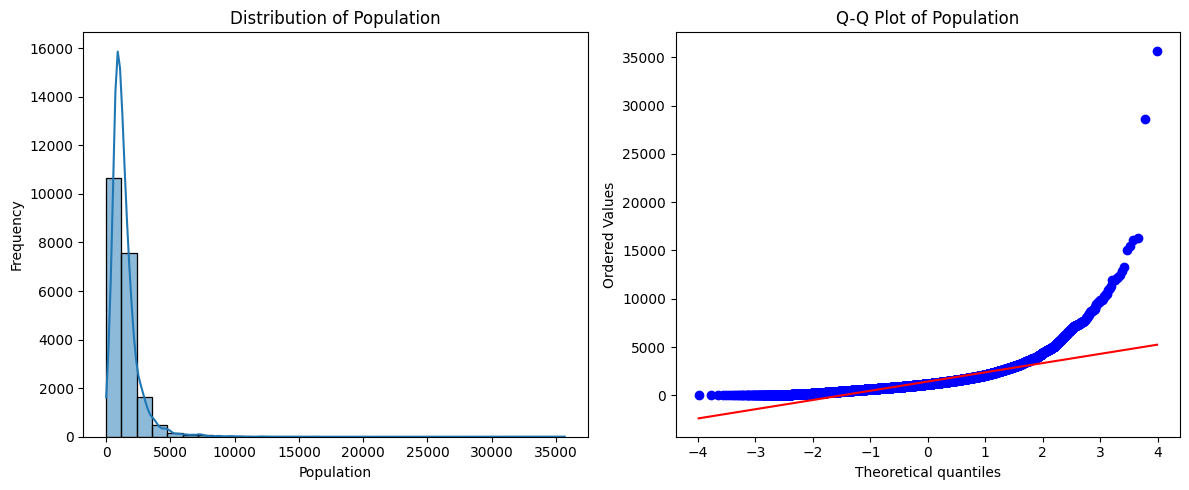

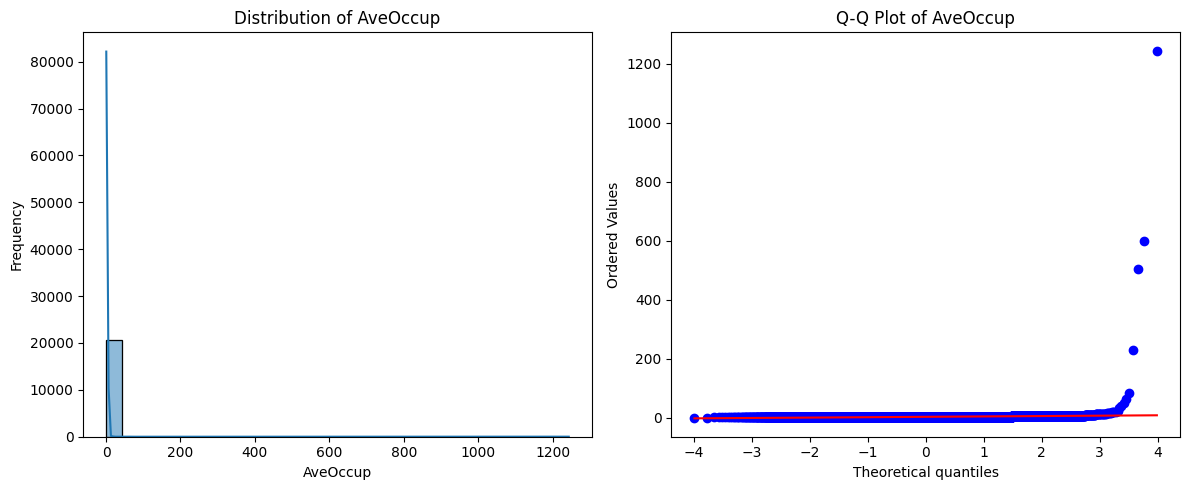

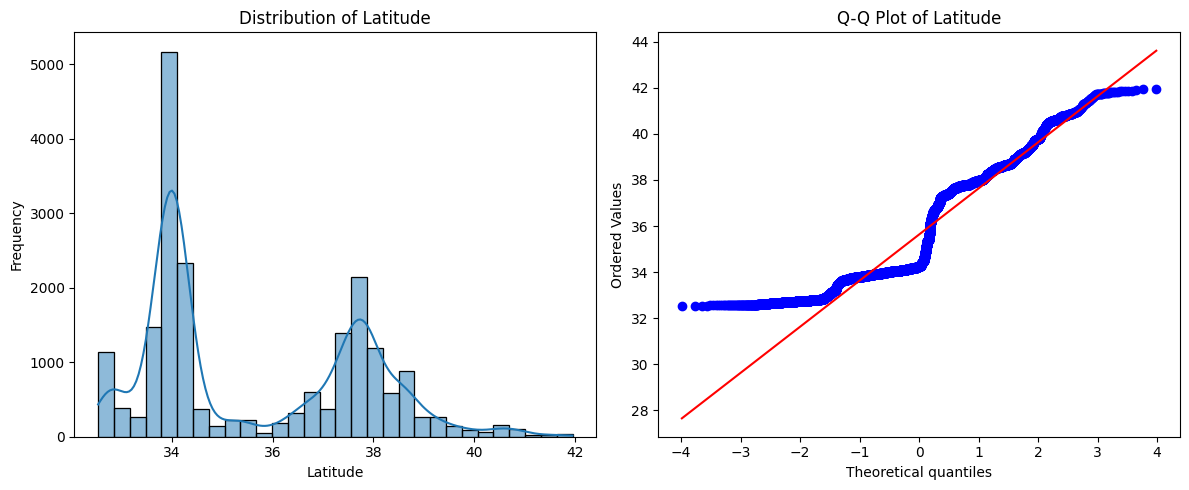

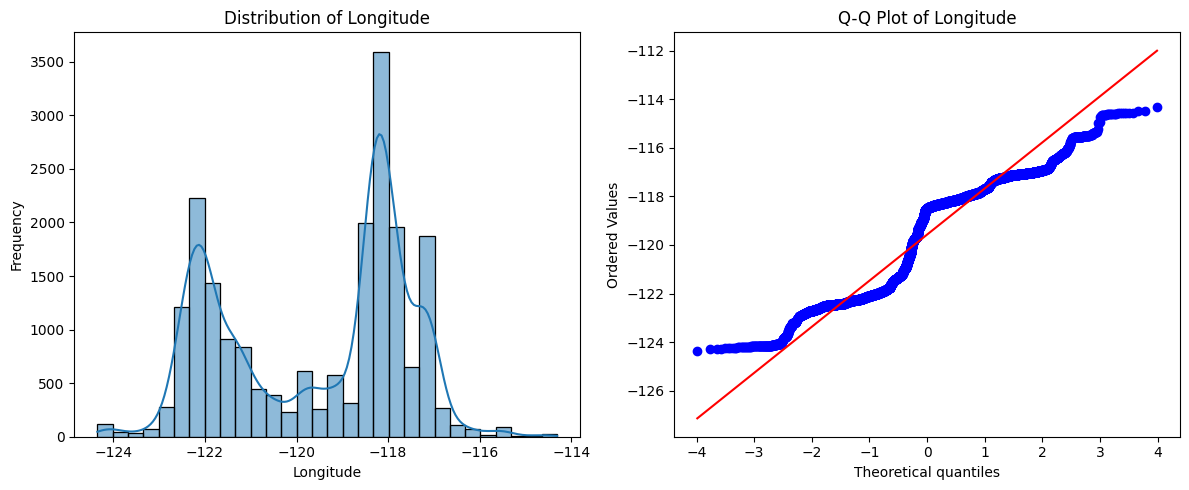

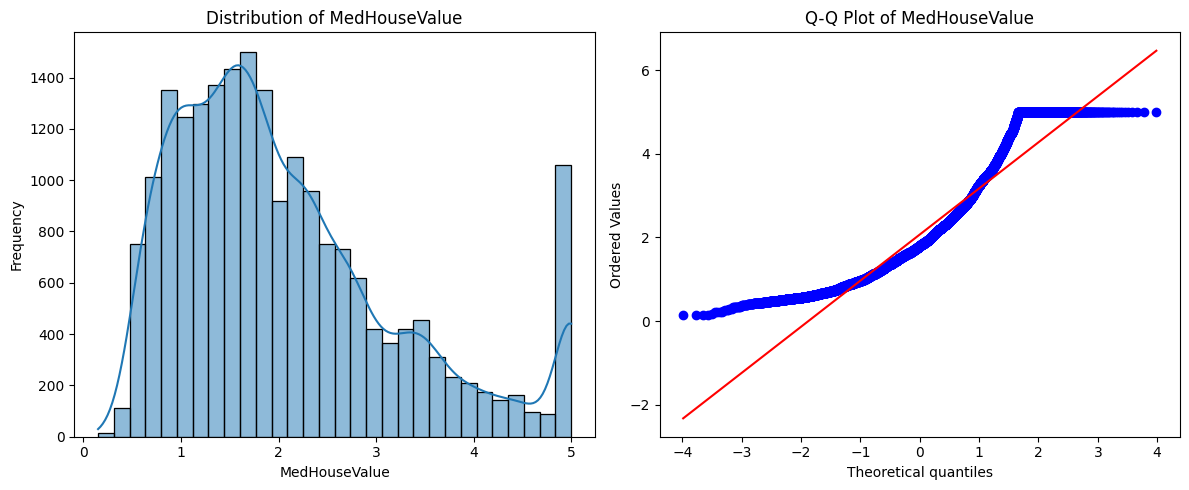

In [231]:
def visualize_skew_kurt(columns):
  for col in columns:
      plt.figure(figsize=(12, 5))

      # Histogram with KDE (Kernel Density Estimate)
      plt.subplot(1, 2, 1)
      sns.histplot(housing[col], kde=True, bins=30)
      plt.title(f'Distribution of {col}')
      plt.xlabel(col)
      plt.ylabel('Frequency')

      # Q-Q plot to check normality
      plt.subplot(1, 2, 2)
      stats.probplot(housing[col], dist="norm", plot=plt)
      plt.title(f'Q-Q Plot of {col}')

      plt.tight_layout()
      plt.show()

visualize_skew_kurt(housing.columns)

- Highly Skewed Inputs: (AveRooms, AveBedrms, Population, AveOccup) can distort regression assumptions — mitigation plans: log/sqrt transformations or removing extreme outliers.

- Multimodal Inputs: (Latitude, Longitude) reflect geographic structure, can be modeled as it is.

- Target Variable (MedHouseValue): Slight right skew, likely capped at maximum value.

- Most variables deviate from normality, so standard linear regression assumptions are not fully met. Transformations or robust regression may be worth exploring, but linear regression may still provide insight if we check residuals after fitting.

**Applying Transformation**

- To correct for high skewness and kurtosis.

- To stabilize variance and reduce the influence of outliers.

- To better satisfy linear regression’s assumption of normality for features and (especially) for residuals.

**Typical transforms:**

- np.log1p(x) for right-skewed, positive features (handles zeros safely).

- np.sqrt(x) as a milder transformation for positive features.

Note: Capping or removing extreme outliers before transformation is beneficial.

In [232]:
# Handling outliers befor transformations
# Below function caps extreme values to reasonable bounds and keeps data shape intact without removing rows.
def cap_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return series.clip(lower=lower_bound, upper=upper_bound)

# Apply capping to columns with high skew/outliers
for col in ['AveRooms', 'AveBedrms', 'AveOccup', 'Population', 'MedInc', 'MedHouseValue']:
    print(f"[Handling outliers for {col}]")
    housing[col] = cap_outliers(housing[col])
    print(f"[Outliers for {col} clipped successfully]")

[Handling outliers for AveRooms]
[Outliers for AveRooms clipped successfully]
[Handling outliers for AveBedrms]
[Outliers for AveBedrms clipped successfully]
[Handling outliers for AveOccup]
[Outliers for AveOccup clipped successfully]
[Handling outliers for Population]
[Outliers for Population clipped successfully]
[Handling outliers for MedInc]
[Outliers for MedInc clipped successfully]
[Handling outliers for MedHouseValue]
[Outliers for MedHouseValue clipped successfully]


In [233]:
# Applying log1p transform to reduce right skewness (safely handles zeros)
transformed_columns = []
for col in ['AveRooms', 'AveBedrms', 'AveOccup', 'MedInc', 'MedHouseValue']:
    #housing[col + '_log'] = np.log1p(housing[col])  # Creates a new column with _log suffix
    housing[col] = np.log1p(housing[col])
    transformed_columns.append(str(col + '_log'))

[FEATURE]: MedInc
skewness: -0.04207638100320755
kurtosis: -0.3798629842370125


[FEATURE]: HouseAge
skewness: 0.06032625301661101
kurtosis: -0.8007255995444988


[FEATURE]: AveRooms
skewness: -0.27695307745984415
kurtosis: 0.33228709266688705


[FEATURE]: AveBedrms
skewness: 0.3482394557519321
kurtosis: 0.10867506975768793


[FEATURE]: Population
skewness: 0.8421860776931033
kurtosis: 0.06419169327886198


[FEATURE]: AveOccup
skewness: 0.034492142934778855
kurtosis: -0.11001260378887157


[FEATURE]: Latitude
skewness: 0.46591914016270397
kurtosis: -1.117779708313892


[FEATURE]: Longitude
skewness: -0.29777956498586855
kurtosis: -1.3301208448425363


[FEATURE]: MedHouseValue
skewness: 0.24328172166470197
kurtosis: -0.6539916706923039




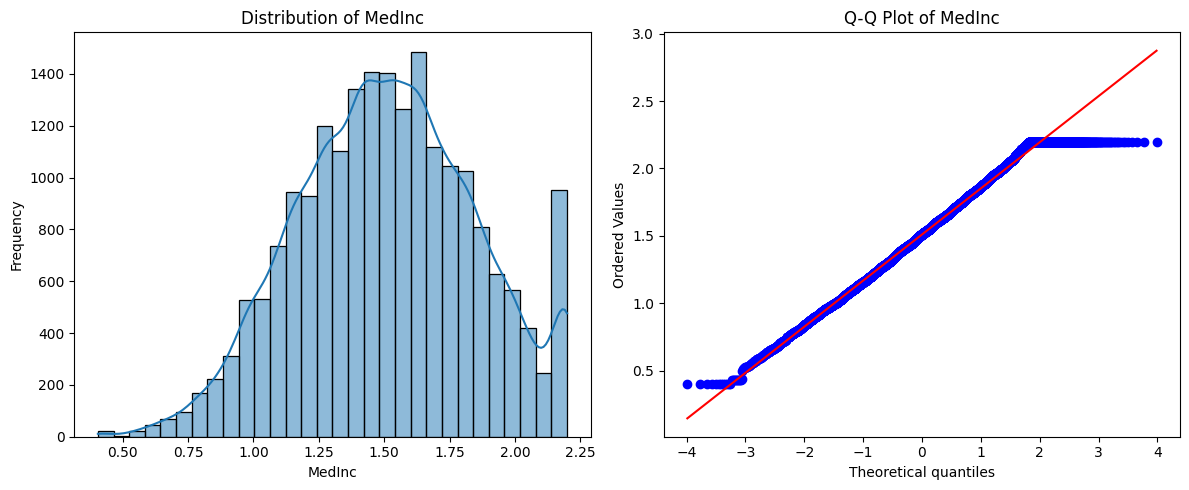

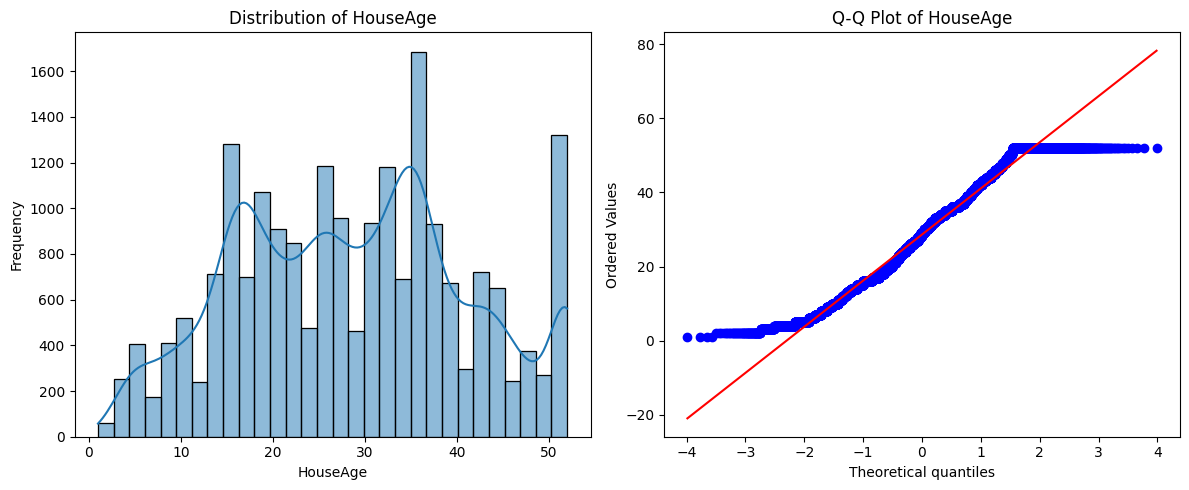

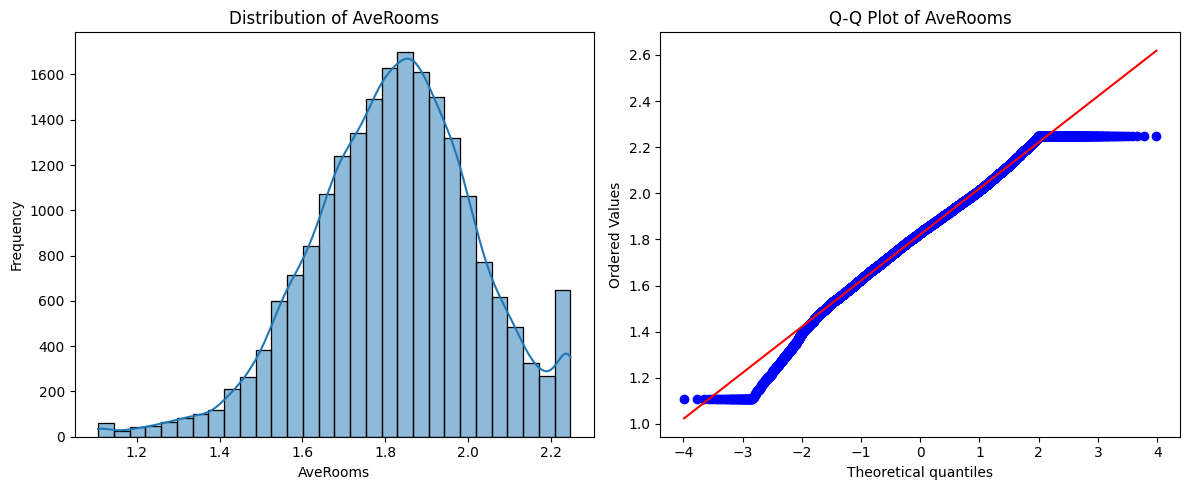

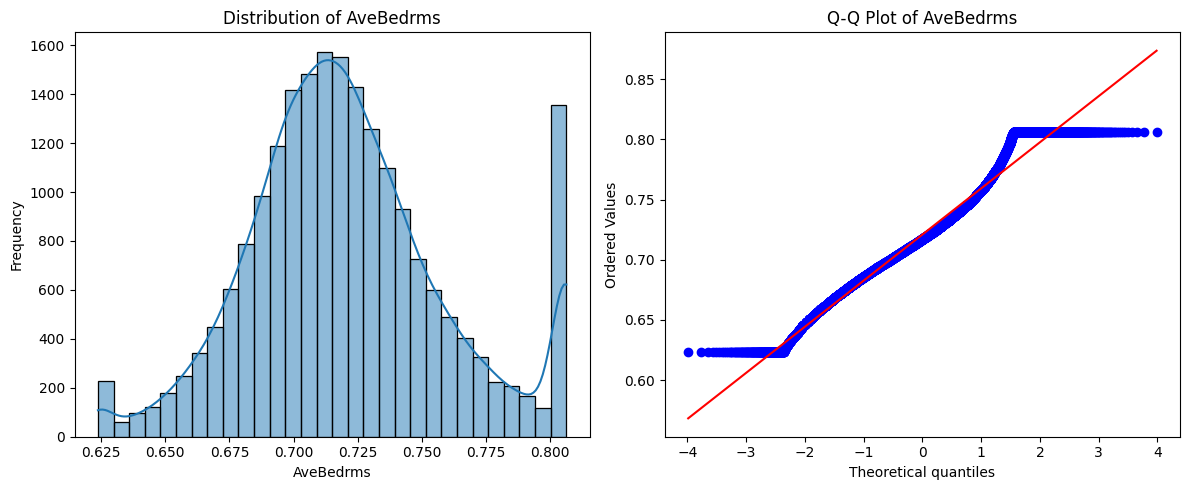

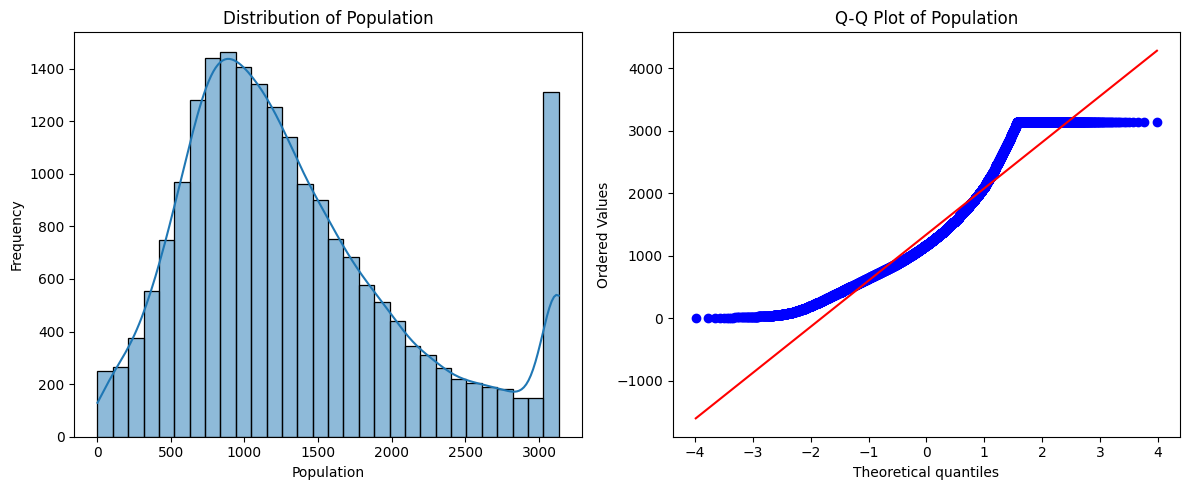

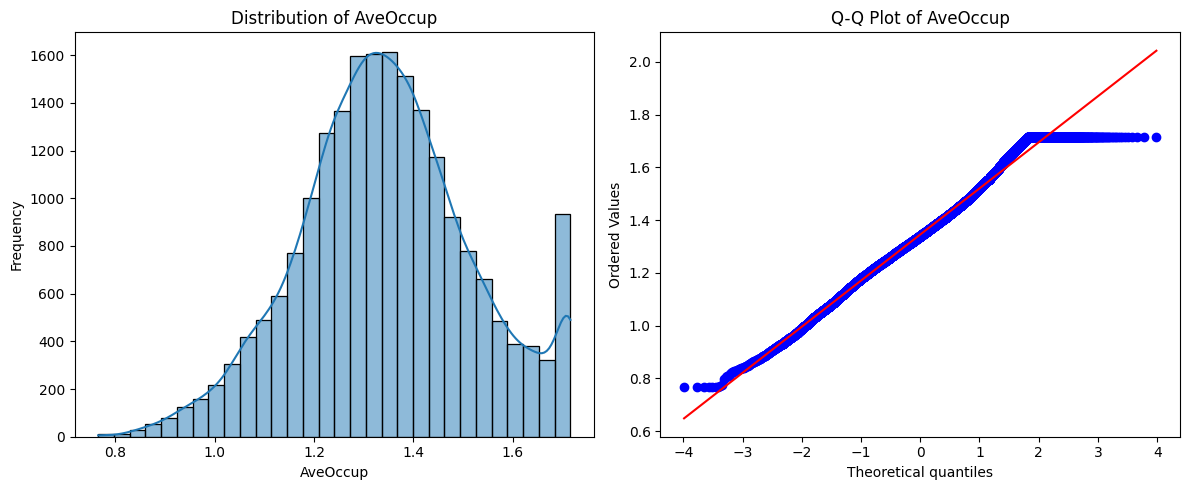

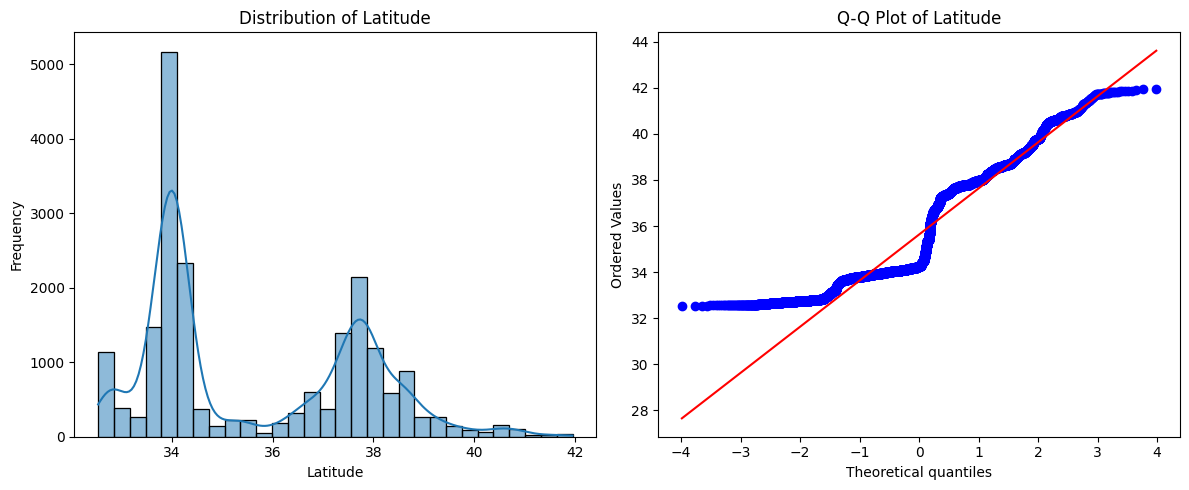

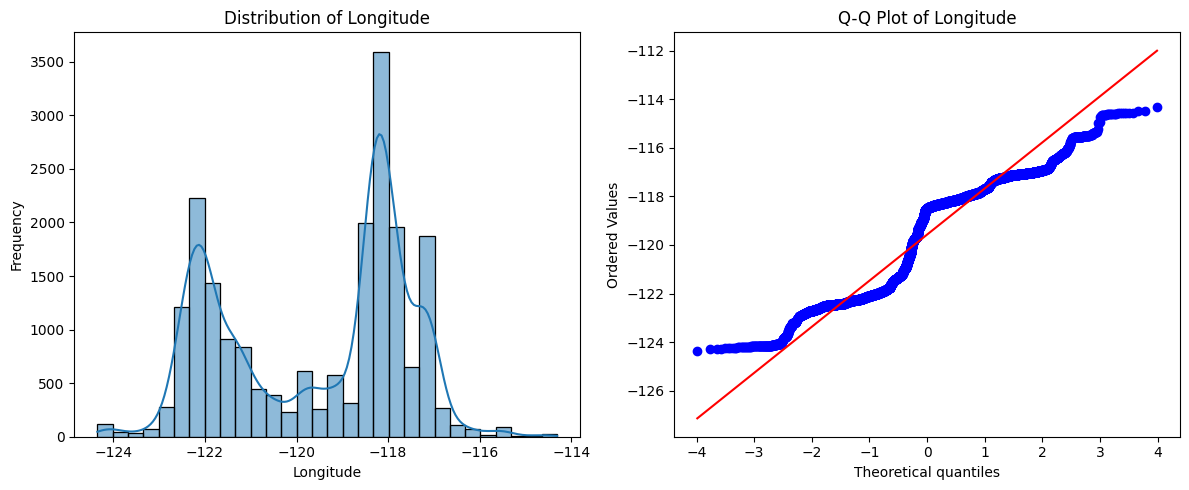

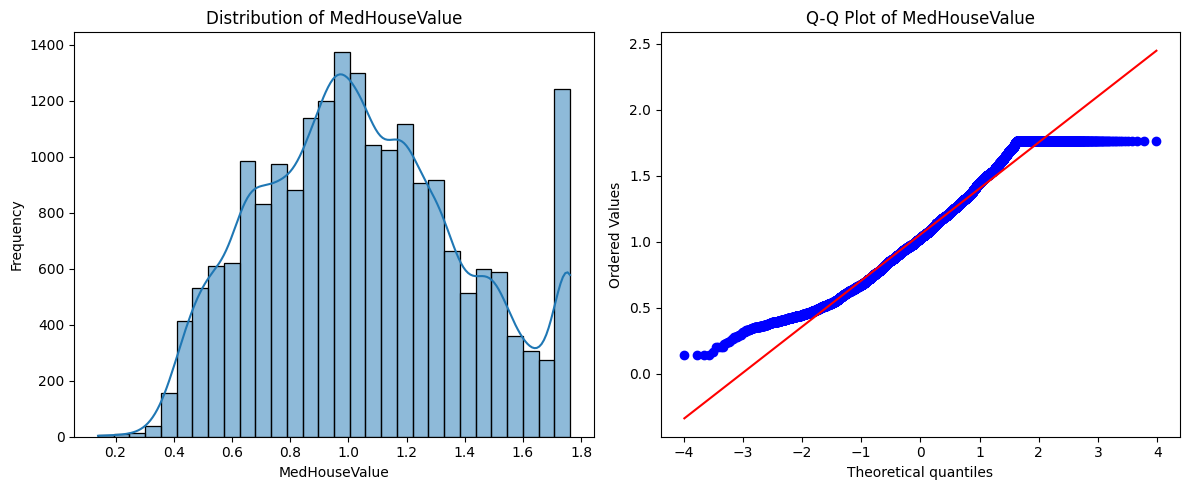

In [234]:
# Rechecking the skewness and kurtosis of transformed columns
skew_kurt(housing.columns)
visualize_skew_kurt(housing.columns)

- All features now have skewness and kurtosis well within conventional “safe” thresholds for linear modeling.

In [235]:
#retaining only clipped columns and dropping transformed columns for now
#housing = housing.drop(columns = list(transformed_columns))
#print(f"[Transformed columns dropped successfully]\nColumns in dataset:{housing.columns.to_list()}")

### Bivariate Analysis

Bivariate analysis involves examining the relationship between two variables. Its goal is to understand how variables are associated—whether they tend to increase together, move inversely, or have no clear relationship.

In the context of your housing data, bivariate analysis helps to:
- Identify correlations: How strongly and in what direction a predictor variable influences the target variable.

- Detect linear or non-linear relationships: Use scatter plots or correlation coefficients.

- Spot potential multicollinearity: When predictor variables are highly correlated with each other, which may affect regression models.

- Guide feature selection: Choosing the most relevant predictors for your model.

**Techniques for Bivariate Analysis:**

- Scatter plots: Visualize the relationship between two continuous variables.

- Correlation coefficient (Pearson’s r): Quantifies the strength and direction of the linear relationship.

- Pair plots: Visualize relationships and correlations among multiple variables simultaneously.

- Cross-tabulations and bar charts: For categorical vs. numerical or categorical vs. categorical variables.

In [236]:
# Scatter plot: predictor vs. target
def predictor_vs_target(predictor, target):
  sns.scatterplot(x=housing[predictor], y=housing[target])
  plt.xlabel(predictor)
  plt.ylabel(target)
  title = predictor + ' vs. ' + target
  plt.title(title)
  plt.show()

# Correlation matrix heatmap
def Correlation_matrix_heatmap():
  plt.figure(figsize=(10,8))
  sns.heatmap(housing.corr(), annot=True, cmap='coolwarm')
  plt.title('Correlation Matrix')
  plt.show()

# Pairplot for multiple features
def pairplot(features):
  sns.pairplot(housing[features])
  plt.show()

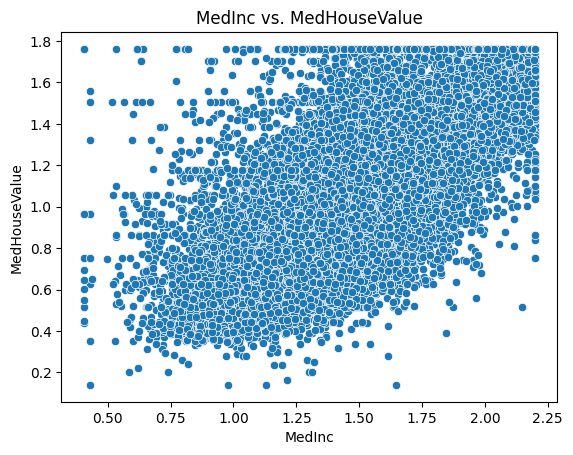

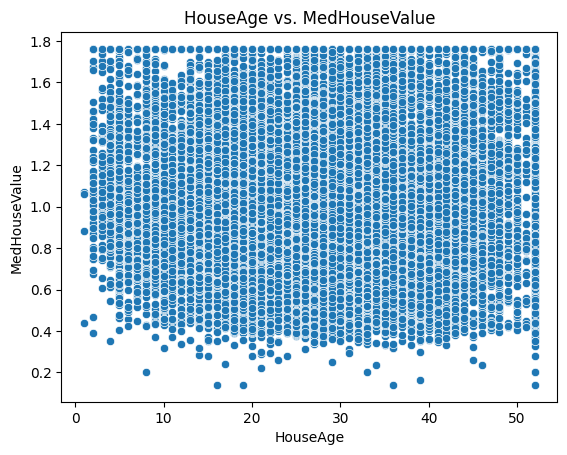

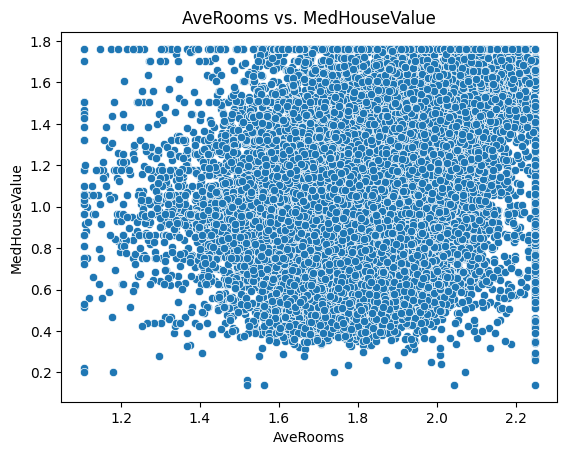

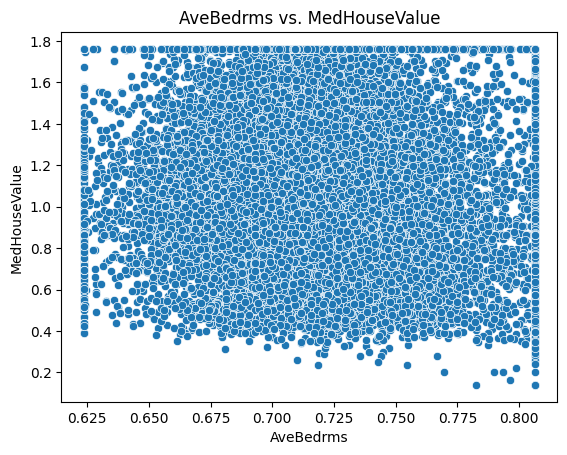

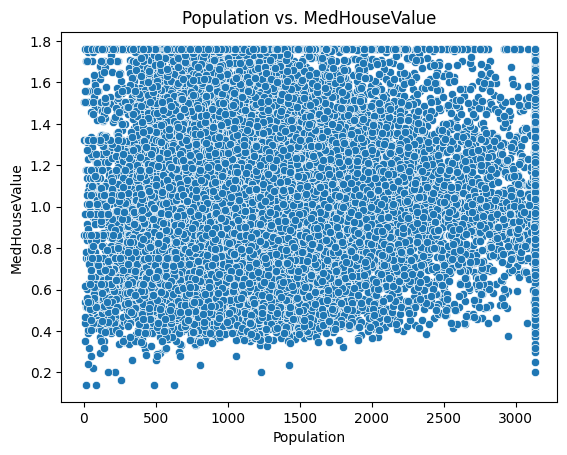

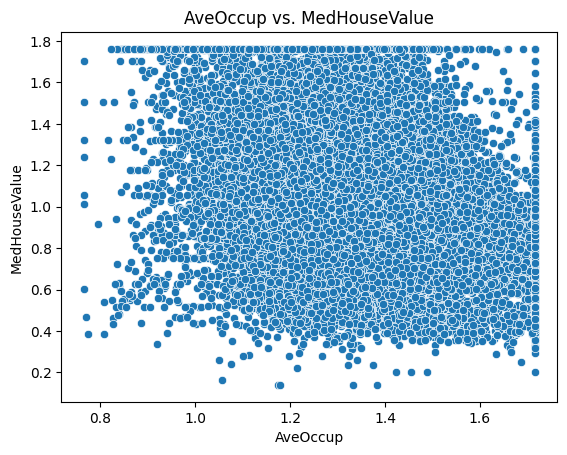

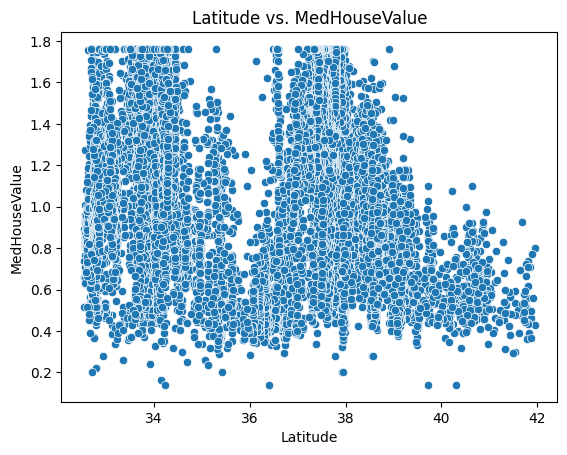

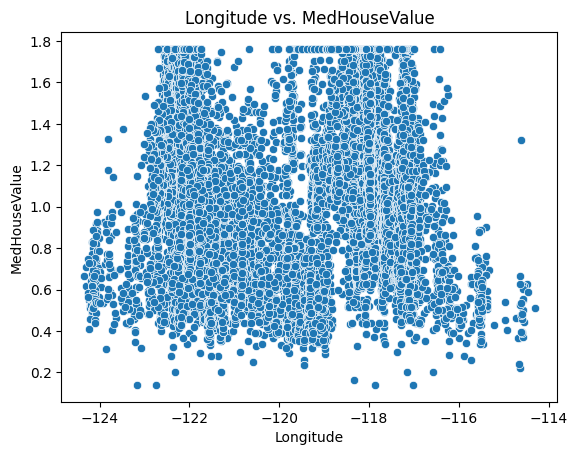

In [237]:
for feature in features:
  predictor_vs_target(feature, target[0])

- `MedInc vs. MedHouseValue`: This plot shows a visible positive trend; as median income increases, median house value tends to rise. This indicates a strong, direct relationship useful for linear regression.

- `HouseAge, Population, AveOccup, AveRooms, AveBedrms vs. MedHouseValue`: These plots do not display clear patterns as data points are widely dispersed, which means these features may have a weaker, more complex, or non-linear influence on house value individually.

- `Latitude and Longitude vs. MedHouseValue`: Distinct vertical clusters are seen, suggesting the impact of geographic regions. House values can vary significantly by location, but not in a strictly linear manner.

In summary, some features (such as MedInc) show a clear relationship with house value, while others show little to no obvious pattern in a bivariate context. This analysis helps identify which predictors are most informative for the regression model.

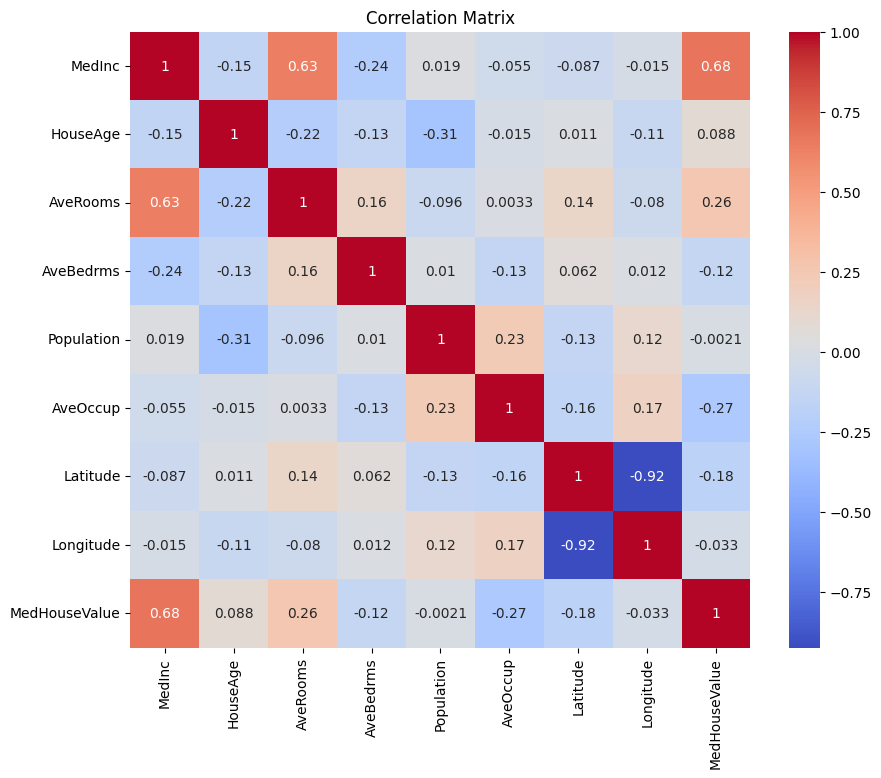

In [238]:
Correlation_matrix_heatmap()

**MedHouseValue (Target):**

- Highest correlation with MedInc (0.69): Median Income is strongly linked to house values.

- Moderate positive correlation with AveRooms (0.31): More rooms tend to be associated with higher house values.

- Negative correlation with AveOccup (-0.28): Higher occupancy relates to lower house values, possibly indicating crowded or more affordable housing.

- Latitude and Longitude have weak correlations with house value, but are highly negatively correlated with each other due to geographic layout.

**Potential Multicollinearity:**

- MedInc and AveRooms (0.66): If both are used in the model, variance inflation due has to be evaluated due to strong collinearity.

- Latitude and Longitude (-0.92): Almost perfectly negatively correlated, reflecting California’s north-south and east-west orientation.

**Other Features:**

- Many features show weak or negligible linear relationships with the target and each other, indicating they may play a secondary or non-linear role.

**Implication For Modeling**
- Features with high correlation to the target (MedInc, AveRooms) should be prioritized.

- Care is needed if using highly correlated predictors together, as multicollinearity can bias regression coefficients.

- Features with weak correlation may require transformation, engineering, or alternative modeling to capture their impact

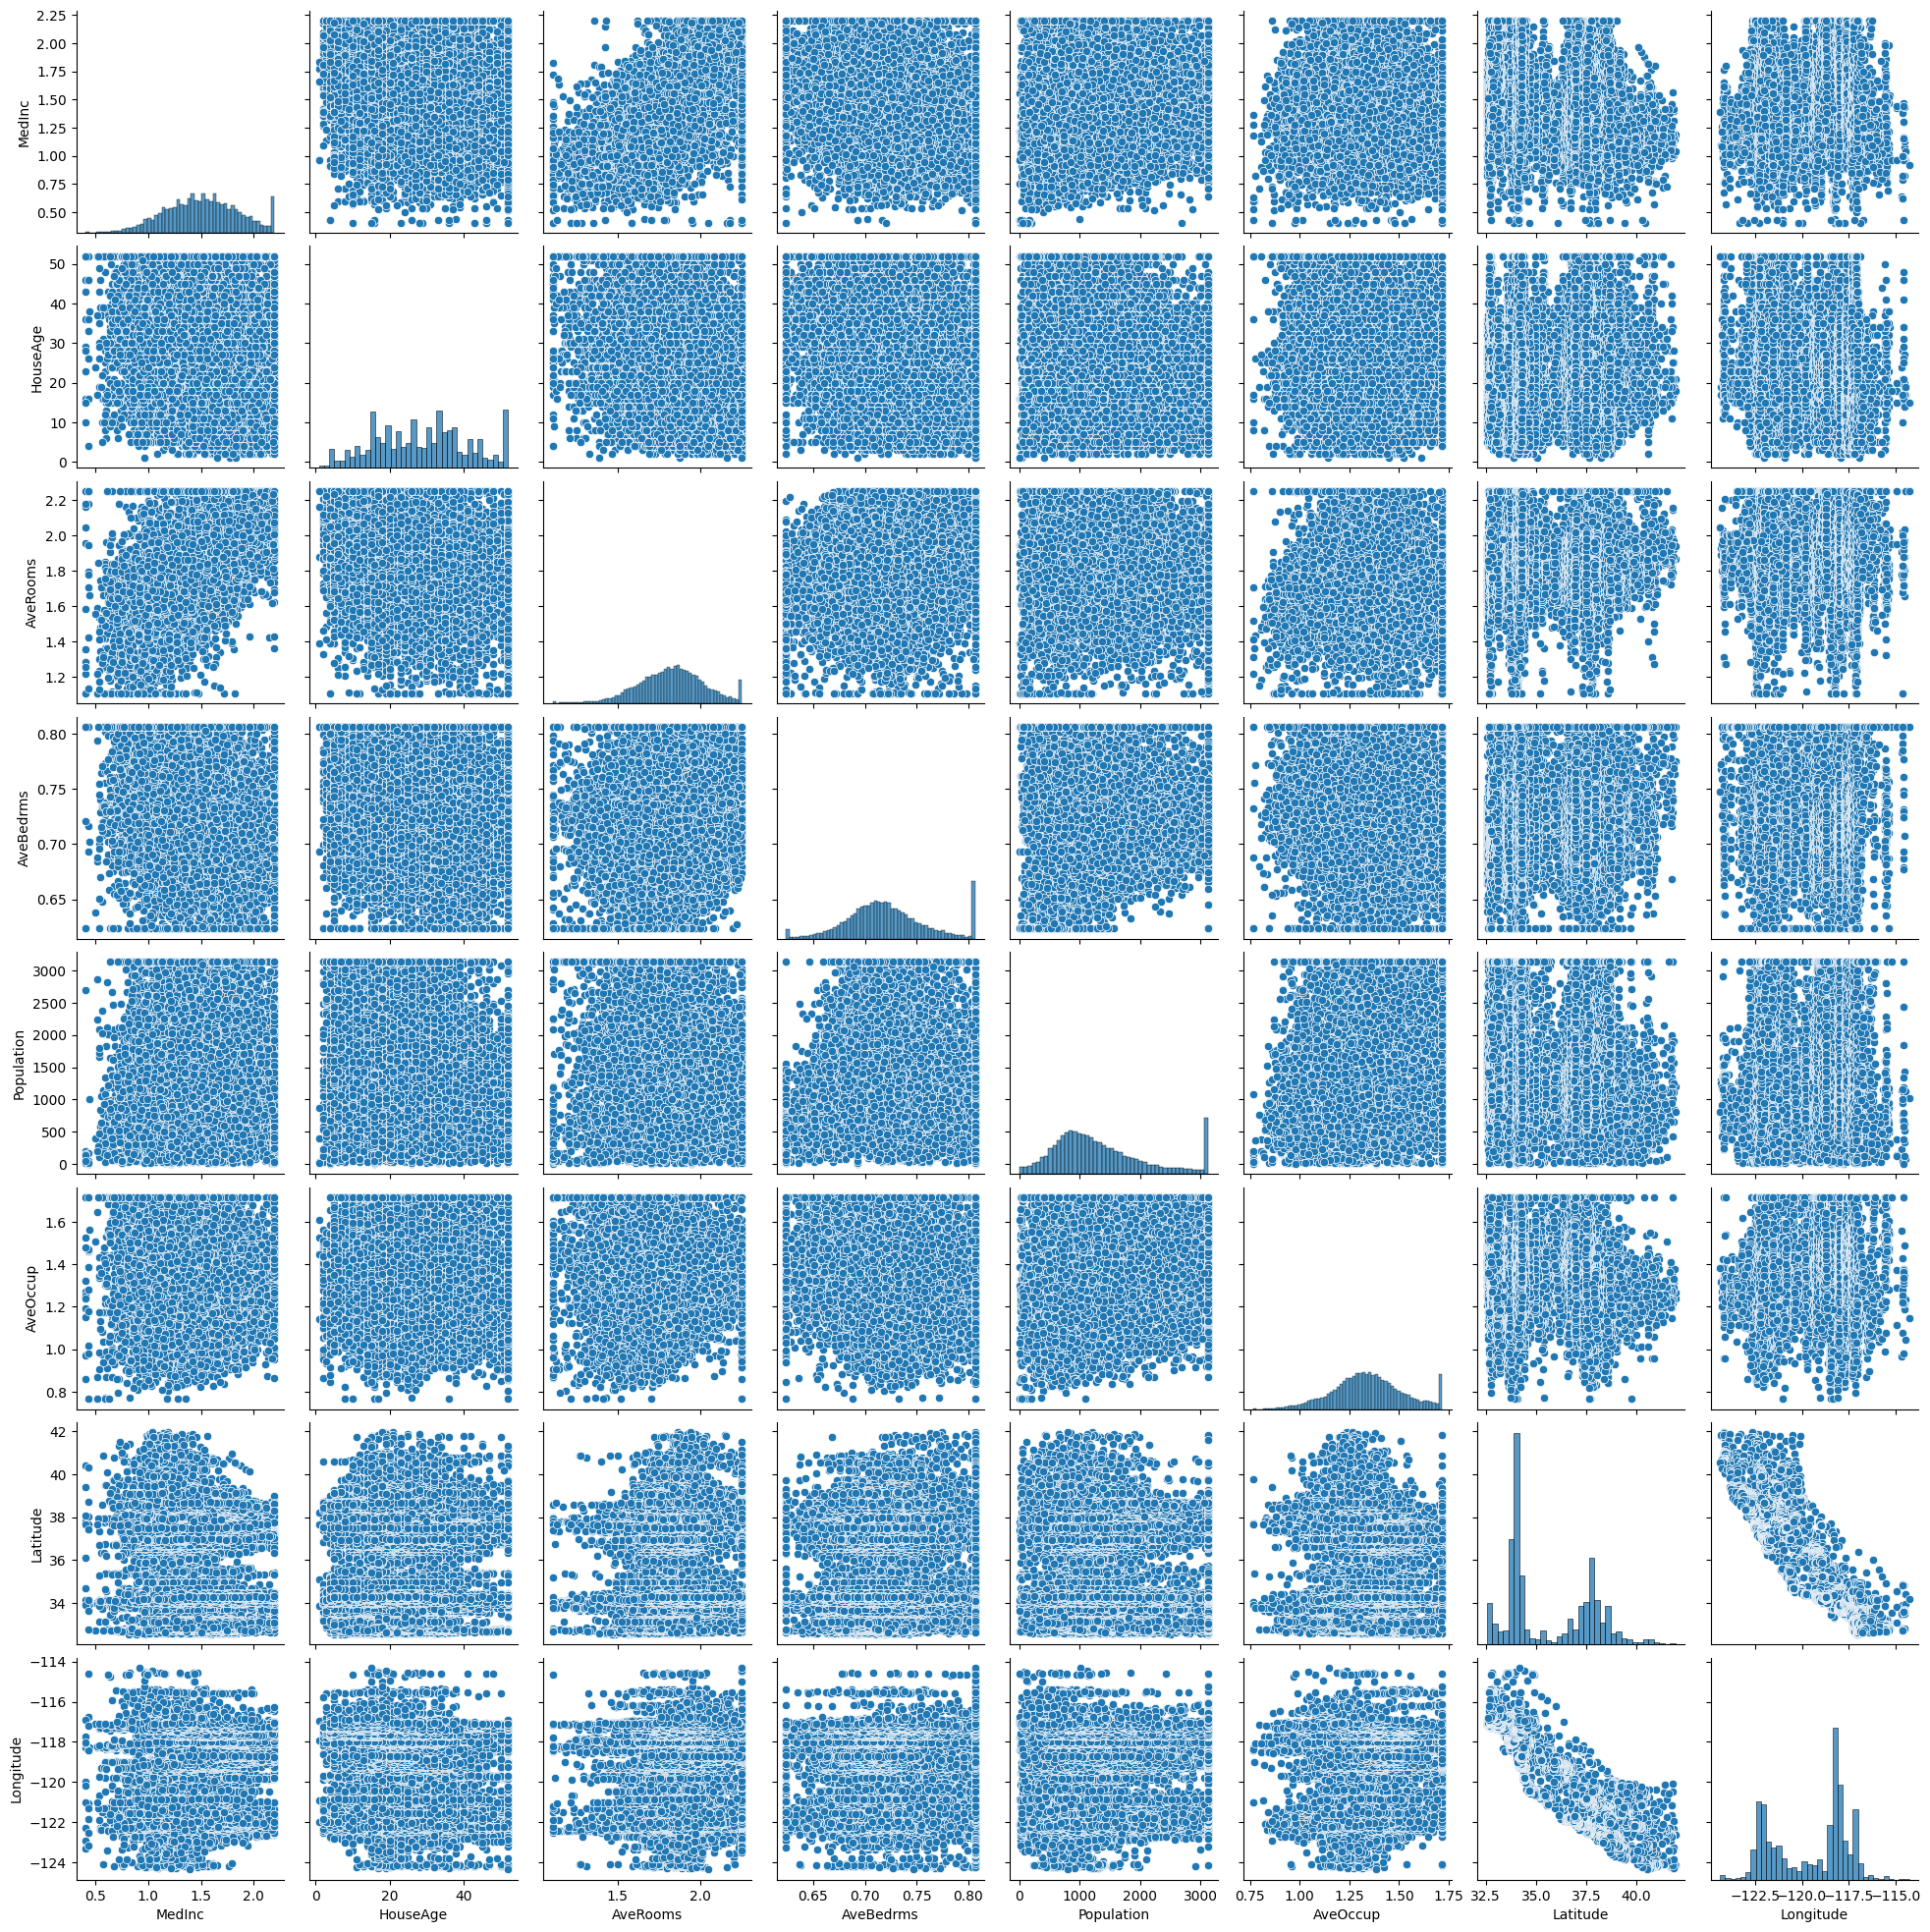

In [239]:
pairplot(features)

1. Strong Predictors to Include
- MedInc (Median Income)

    - Highest correlation with MedHouseValue (~0.69).

    - Clear positive linear relationship in scatterplots.

    - Moderate skewness, improved after transformation/clipping.

- AveRooms (Average Rooms)

    - Moderate positive correlation (~0.31) with MedHouseValue.

    - Shows a moderately positive trend with house value in plots.

    - Skewness reduced to acceptable levels post-transformation.


2. Features to Use with Caution
- AveBedrms (Average Bedrooms)

    - Weak negative correlation with house value (~-0.10).

    - Weak scatterplot pattern and skewness reduced after transformation but still less predictive; consider feature engineering or testing impact in model.

- AveOccup (Average Occupancy)

    - Moderate negative correlation (~-0.28).

    - Relationship is less direct; useful to test but possibly less impactful.

3. Features Likely to Exclude or Transform Further
- Population, HouseAge

    - Very weak/no correlation with target (close to zero or low) and scattered bivariate plots.

    - Despite importance intuitively (e.g., population density), low linear association suggests possible non-linear relationship or low predictive power in current form.

- Latitude and Longitude

  - Low correlation with target, spatial clustering evident; may be better handled with spatial models or engineered location features (e.g., distance to urban centers).

  - Using raw geographic features directly in linear regression is unlikely to provide straightforward predictive power.

4. Multicollinearity Considerations

- MedInc and AveRooms have strong correlation (~0.66).

    - Check Variance Inflation Factor (VIF) during modeling to avoid instability.

If high multicollinearity arises, it is essential to consider dropping or combining one of these correlated features.

### Multivariate Analysis


Multivariate analysis examines how multiple features act together in relation to the target or each other. It helps uncover interactions, combined effects, and higher-order relationships that bivariate analysis alone cannot reveal.

**Use Cases:**

- Detecting multicollinearity (when two or more predictors are highly correlated, affecting model coefficients).

- Evaluating the combined predictive power of variables (for linear regression or other models).

- Exploring interactions (e.g., how two features together influence the target, even if their individual impact is minor).

**Methods:**

- Correlation matrix and VIF (Variance Inflation Factor) for collinearity.

- Multivariate plots (e.g., 3D scatterplots, pairplot sub-selection, or PCA for dimensionality reduction).

- Multiple linear regression as a multivariate modeling tool.

In [240]:
# baseline: considering all features, modify below for feature selection and multi-collinearity evaluation
# features = ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup']
# target = 'MedHouseValue'

X = housing[features]
y = housing[target]


In [241]:
# Calculate VIF for each feature
def vif_evaluation(X):
  vif_df = pd.DataFrame()
  vif_df['feature'] = X.columns
  vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  print(vif_df)

vif_evaluation(X)

      feature          VIF
0      MedInc    51.749607
1    HouseAge     7.645275
2    AveRooms   202.342800
3   AveBedrms   466.546269
4  Population     5.033985
5    AveOccup    68.047052
6    Latitude   680.891513
7   Longitude  1744.257325


**VIF Interpretation**
- VIF > 5: Potential multicollinearity problem, can distort regression estimates and make coefficients unreliable.

- VIF > 10: Severe multicollinearity; action is almost always required.

**Recommendations**
- Centering

- Dropping either AveRooms or AveBedrms (preferably AveBedrms, given its astronomical VIF).

- Dropping one or both of Latitude and Longitude (unless using them in a special way, such as for spatial models).

- Consider removal or transformation of AveOccup.

In [242]:
import pandas as pd

# Assume X is your DataFrame of predictors
X_centered = X.copy()

# Center each predictor
def center_predictors(X):
    for col in X.columns:
        X[col] = X[col] - X[col].mean()
        return X

X_centered = center_predictors(X_centered)

# Now fit your model using X_centered instead of original X
vif_evaluation(X_centered)

      feature          VIF
0      MedInc     2.439357
1    HouseAge     7.637172
2    AveRooms   197.340839
3   AveBedrms   468.541914
4  Population     5.036842
5    AveOccup    68.227159
6    Latitude   636.134094
7   Longitude  1456.961422


Since multicollinearity has major impact on the interpretability of individual features (towards it's contribution to prediction of target variable), we intuitively consider centering of features for our baseline model rather than removal of any features.

In [243]:
#Centering features in the dataset
housing_centered = housing.copy()

for col in housing_centered.columns:
  if col != target[0]:
    housing_centered[col] = housing_centered[col] - housing_centered[col].mean()
    print(f"[Feature {col}: Centered successfully]")
  else:
    print(f"[Feature {col}: Not centered as target]")

[Feature MedInc: Centered successfully]
[Feature HouseAge: Centered successfully]
[Feature AveRooms: Centered successfully]
[Feature AveBedrms: Centered successfully]
[Feature Population: Centered successfully]
[Feature AveOccup: Centered successfully]
[Feature Latitude: Centered successfully]
[Feature Longitude: Centered successfully]
[Feature MedHouseValue: Not centered as target]


## Modelling

In [244]:
# Define predictors and target
X = housing_centered[features]
#X = X.drop(columns=['AveBedrms','Longitude','Latitude'])
y = housing_centered[target[0]]

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Printing shape of all dataset
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (16512, 8), y_train shape: (16512,)
X_test shape: (4128, 8), y_test shape: (4128,)


In [245]:
# Determing the best value of alpha to apply L2 (Ridge) Regularization

ridge = Ridge()
params = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}

grid = GridSearchCV(ridge, param_grid=params, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_['alpha'])
print("Best R2 score:", grid.best_score_)

Best alpha: 0.01
Best R2 score: 0.6821982965126612


In [248]:
# Ridge Regression
ridge = Ridge(alpha=0.01)  # alpha controls regularization strength
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
print(f'Ridge R2 score: {r2_score(y_test, y_pred_ridge):.4f}')

Ridge R2 score: 0.6664


R-squared: 0.6664
MSE: 0.0414
RMSE: 0.2034
MAE: 0.1544


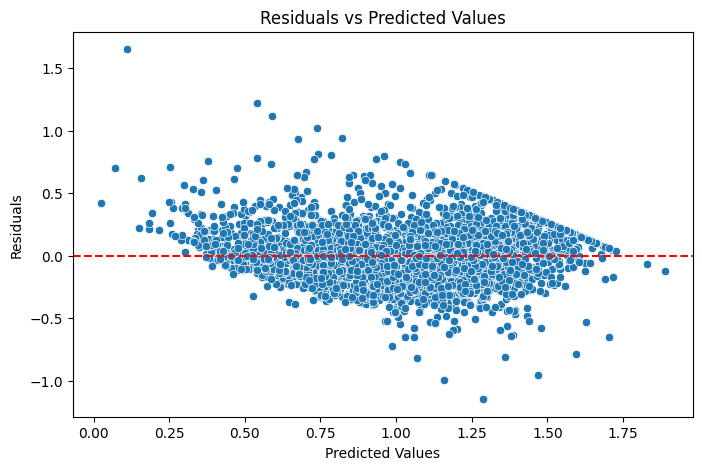

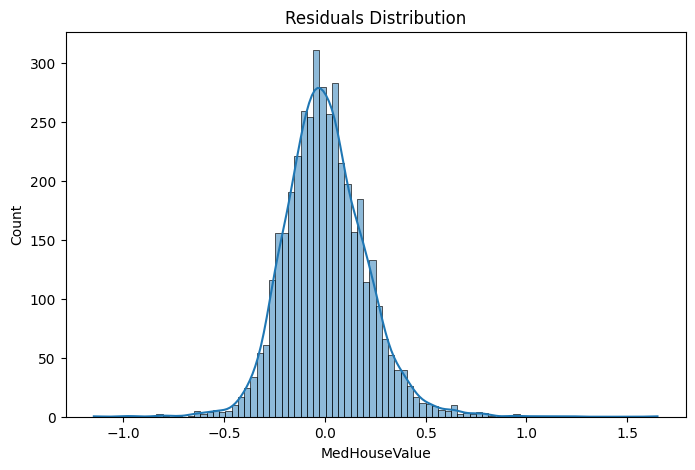

In [249]:
# Predictions on test data
y_pred = ridge.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'R-squared: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, ls='--', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()


**Critical Summary and Recommendations**

`Output Interpretation`

- The Ridge regression model, using log1p-transformed features and capped Population, achieved an R² of 0.6664, MSE of 0.0414, RMSE of 0.2034, and MAE of 0.1544. These scores confirm the model can predict median house values with reasonable accuracy, explaining about two-thirds of the variance in the outcome.

- Residuals are nearly normally distributed and transformation has reduced but not eliminated heteroscedasticity, suggesting improvement in both error distribution and model reliability.

`Causes Behind the Outputs`

- Feature Transformation: Log1p transformation stabilized feature distributions and mitigated effects of extreme values, particularly benefiting linear relationships and variance assumptions.

- Capped Population: Clipping outlier values improved robustness without distorting the effect of the Population variable, preserving useful signal while limiting leverage points.

- Regularization (Ridge): L2 penalty reduced overfitting and dampened the impact of multicollinearity among features, leading to more stable coefficient estimates.

- Feature Engineering Choices: The combination of transformation, capping, and regularization helped achieve a balance between model interpretability and predictive accuracy.

`Areas for Improvement`

- Residual Patterns: Remaining heteroscedasticity and subtle patterns in residuals highlight missing non-linear relationships or interactions. Exploring polynomial features, interaction terms, or tree-based models (e.g., Random Forest or Gradient Boosting) could address this.

- Feature Selection: Further investigation into feature importance or alternative transformations (e.g., target transformation, Box-Cox) may enhance results.

- Validation: External validation using unseen data or cross-validation schemes would help test model generalizability and avoid optimistic fit assessment.

`Practicality and Real-World Use`

- With an R² in the mid-0.60s, this model is practically acceptable for initial prediction and exploratory analysis in real-world housing scenarios—especially where explainability and speed matter.

- For high-stakes applications (e.g., banking, investments, resource allocation), additional accuracy and robustness would likely be required. This could be achieved by upgrading the modeling strategy (ensembles, non-linear methods) and integrating richer feature sets, spatial information, or temporal trends.

- The current model is interpretable, fast, and transparent, making it attractive in contexts where stakeholders need clear understanding and swift deployment.

`Next Steps and Recommendations`

- Experiment with advanced models (polynomial, ensemble, or tree-based) to capture more complex signal.

- Perform rigorous validation with alternative data splits or time/space-based holdouts.

- Fine-tune regularization and feature transformations for further incremental gains.

- Summarize findings to stakeholders with both statistical metrics and practical implications, addressing model strengths and limitations plainly.